In [8]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat
import os
from datetime import datetime
import json

In [ ]:
def SimPhotDiffFlowGL6(C_molar, Rp, D, totalTime, binDt, w0, axialFactor, includeBg, bgRate, beamShape, vFlow, resFactor=10):
    """
    SimPhotDiffFlowGL6  Simulate photon arrivals via sweeping reservoir + reflection
    Core elements:
        - Pre-generated reservoir spanning resFactor * Lbox in x, ±Lbox in y,z
        - Advective flow + diffusion each dt-step
        - Diffusion: reflecting boundaries in excitation volume (±Lbox)
        - No births/deaths: sweeping reservoir reused via column-wise permutation
        - Photon thinning via fixed dt binning
        - Binning and preview via RebinIntensity
            This two-stage randomness
        
            Stage 1 (brightness jitter): Ri=biRp with bi drawn once from a non-Poisson distribution.
        
            Stage 2 (shot noise): photon counts in each Δt are Poisson with mean ∑RiWiΔt.
        
    Inputs:
        C_molar     - concentration [mol/L]
        Rp          - emission rate at beam center [photons/s]
        D           - diffusion coefficient [m^2/s]
        totalTime   - total simulation duration [s]
        binDt       - time bin width [s]
        w0          - lateral beam waist [m]
        axialFactor - ratio w_z/w0 (unitless)
        includeBg   - boolean: include Poisson background
        bgRate      - background rate [photons/s]
        beamShape   - 'gaussian' or 'gl'
        vFlow       - advective flow speed in x [m/s]
        resFactor   - reservoir length factor (multiples of Lbox) in x (default 10)
    Outputs:
        arrivalTimes - photon timestamps [s]
        counts       - counts per bin
        timeBins     - bin centers [s]
    """

    # if resFactor == 10:
    #     pass
    # if vFlow == 0:
    #     pass

    # 1) Geometry & Constraints
    NA = 6.022e23                   # Avogadro (#/mol)
    C_m3 = C_molar * 1e3            # mol/L --> mol/m^3
    w_z = axialFactor * w0          # axial waist [m]
    Lbox = 5 * max(w0, w_z)         # half-box size [m]
    Lres = resFactor * Lbox         # reservoir half-length [m]


    # 2) Reservoir initialization
    area_yz = (2*Lbox)**2           # cross-section area [m^2]
    Vres = (2*Lres) * area_yz       # reservoir volume [m^3]
    Nres = max(1, np.random.poisson(C_m3 * NA * Vres))  # reservoir molecules (>=1)
    # Uniform positions in x∈[-Lres,Lres], y, z∈[-Lbox,Lbox]
    x = (np.random.rand(Nres,1)-0.5)*2*Lres
    y = (np.random.rand(Nres,1)-0.5)*2*Lbox
    z = (np.random.rand(Nres,1)-0.5)*2*Lbox
    pos = np.concatenate([x, y, z], axis=1)

    # 3) Time step and diffusion
    dt = binDt                      # timestep [s]
    sigma = np.sqrt(2 * D * dt)     # diffusion std [m]
    nSteps = np.ceil(totalTime/dt).astype(int)
    if vFlow > 0:
        stepsPerSweep = np.ceil((2*Lres) / (vFlow * dt)).astype(int)
    else:
        stepsPerSweep = float('inf')

    # 4) Preallocate photon times
    Veff = np.pi ** (3/2) * w0**2 * w_z                 # focal vol [m^3]
    Navg = C_m3 * NA * Veff         # avg in focus
    expCount = np.ceil((Navg*Rp + bgRate) * totalTime * 1.2).astype(int)
    arrivalTimes = []#np.zeros((expCount, 1))
    idx = 0

    # 4.5) Other noise effects in emission (particle brightness variation)
    # std of brightness fluctuations (e.g. 0.2 for ±20% jitter)
    sigma_b = 0.2
    #per molecule brightness factors, mean = 1
    #b = np.exp(sigma_b * np.random.randn(Nres, 1) - 0.5 * sigma_b**2)
    Rp_i = np.exp(np.random.normal(loc=np.log(Rp), scale=sigma_b, size=(Nres, 1)))


    # 5) Simulation loop
    for k in range(1, nSteps+1):
        t0 = (k-1) * dt

        # 5a) Advect reservoir in x
        pos[:, 0] = pos[:, 0] + vFlow * dt

        # 5a-ii) Periodic wrap full reservoir in x
        pos[:, 0] = np.mod(pos[:, 0] + Lres, 2*Lres) - Lres


        # 5b) Diffuse particles within excitation volume
        inBox = np.abs(pos[:, 0]) <= Lbox
        pos[inBox, :] = pos[inBox, :] + sigma * np.random.randn(np.sum(inBox), 3)

        # 5c) Reflecting boundaries for diffusion inBox
        # reflect x
        ix = inBox & (pos[:, 0] > +Lbox)
        pos[ix, 0] = 2*Lbox - pos[ix, 0]
        ix = inBox & (pos[:, 0] < -Lbox)
        pos[ix, 0] = -2 * Lbox - pos[ix, 0]
        # reflect y
        iy = inBox & (pos[:, 1] > +Lbox)
        pos[iy, 1] = 2*Lbox - pos[iy, 1]
        iy = inBox & (pos[:, 1] < -Lbox)
        pos[iy, 1] = -2*Lbox - pos[iy, 1]
        #reflect z
        iz = inBox & (pos[:, 2] > +Lbox)
        pos[iz, 2] = 2*Lbox - pos[iz, 2]
        iz = inBox & (pos[:, 2] < -Lbox)
        pos[iz, 2] = -2 * Lbox - pos[iz, 2]

        # 5d) Photon emission + background counts
        xy2 = np.power(pos[:, 0], 2) + np.power(pos[:, 1], 2)
        z2 = np.power(pos[:, 2], 2)

        if beamShape.lower() == 'gaussian':
                W = np.exp(-2 * xy2/w0**2 - 2*z2/w_z**2)
        elif beamShape.lower() == 'gl':
                Wlat = np.exp(-2*xy2/w0**2)
                Wax = 1 / (1 + z2/w_z**2)
                W = Wlat * Wax
        else:
            raise ValueError(f"Unknown beamShape: {beamShape}")
            
        # Rtot = Rp * np.sum(W)
        #Rtot = Rp * np.sum(b.flatten() * W)           # photons/s with particle brightness variation
        Rtot = np.sum(Rp_i.flatten() * W)
        Nph = np.random.poisson(Rtot * dt)
        if includeBg:
            Nbg = np.random.poisson(bgRate * dt)
        else:
            Nbg = 0
        NtotEv = Nph + Nbg
        if NtotEv > 0:
            arrivalTimes.extend((t0 + np.random.rand(NtotEv) * dt).tolist())
            #arrivalTimes[idx:idx+NtotEv, 0] = (t0 + np.random.rand(NtotEv, 1) * dt)
            idx += NtotEv

        # 5e) Permute reservoir columns every full sweep
        if np.mod(k, stepsPerSweep) == 0:
            perm = np.random.permutation(Nres)
            pos[:, 0] = pos[perm, 0]
            perm = np.random.permutation(Nres)
            pos[:, 1] = pos[perm, 1]
            perm = np.random.permutation(Nres)
            pos[:, 2] = pos[perm, 2]
    # 6) Trim arrivals
    arrivalTimes = np.array(arrivalTimes)
    arrivalTimes = arrivalTimes[:idx-1]

    # 7) Bin into intensity trace
    edges = np.arange(0, totalTime, binDt)
    counts, _ = np.histogram(arrivalTimes, bins=edges)
    timeBins = edges[:-1] + binDt/2


    return arrivalTimes, counts, timeBins, Rp_i

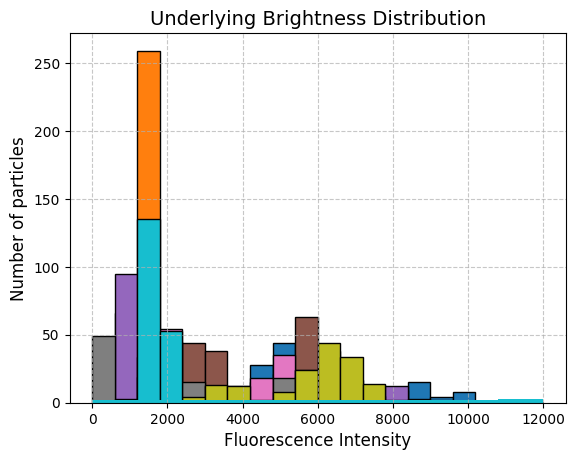

In [ ]:
data_dir = "PCHdataset_LC"
os.makedirs(data_dir, exist_ok=True)
num_sims = 3
for sim_num in range(num_sims):

    sim_dir = os.path.join(data_dir, f"sim_{sim_num:07}")
    os.makedirs(sim_dir, exist_ok=True)


    num_species = np.random.randint(1,4) #[1,3]
    AmpS1 = np.random.randint(500, 3000)
    AmpS2 = np.random.randint(AmpS1+1500, AmpS1+1500+2000)
    AmpS3 = np.random.randint(AmpS2+1500, AmpS2+1500+2500)
    total_conc = np.random.uniform(9e-12, 7e-11)
    min_frac = 0.15

    while True:
        fractions = np.random.dirichlet([1.5] * num_species)
        if np.all(fractions > min_frac):
            break

    Frac1 = fractions[0]
    Frac2 = fractions[1] if num_species >= 2 else 0.0
    Frac3 = fractions[2] if num_species == 3 else 0.0
    conc1 = Frac1 * total_conc
    conc2 = Frac2 * total_conc
    conc3 = Frac3 * total_conc

    truedist1 = np.array([])
    truedist2 = np.array([])
    truedist3 = np.array([])
    at1 = np.array([])
    at2 = np.array([])
    at3 = np.array([])


    arrivalTimes1, counts, timeBins, Rp_i1 = SimPhotDiffFlowGL6(C_molar = conc1,
                                                        Rp = AmpS1/500e-6, 
                                                        D = 1e-12, 
                                                        totalTime = 60, 
                                                        binDt = 1e-6, 
                                                        w0 = 3e-7, 
                                                        axialFactor = 3, 
                                                        includeBg = True, 
                                                        bgRate = 1e2, 
                                                        beamShape = 'gl',
                                                        vFlow=5e-4)
    truedist1 = Rp_i1
    at1 = arrivalTimes1
    if num_species >= 2:
        arrivalTimes2, counts, timeBins, Rp_i2 = SimPhotDiffFlowGL6(C_molar = conc2,
                                                            Rp = AmpS2/500e-6, 
                                                            D = 1e-12, 
                                                            totalTime = 60, 
                                                            binDt = 1e-6, 
                                                            w0 = 3e-7, 
                                                            axialFactor = 3, 
                                                            includeBg = False, 
                                                            bgRate = 0, 
                                                            beamShape = 'gl',
                                                            vFlow=5e-4)
        truedist2 = Rp_i2
        at2 = arrivalTimes2
    if num_species == 3:
        arrivalTimes3, counts, timeBins, Rp_i3 = SimPhotDiffFlowGL6(C_molar = conc3,
                                                            Rp = AmpS3/500e-6, 
                                                            D = 1e-12, 
                                                            totalTime = 60, 
                                                            binDt = 1e-6, 
                                                            w0 = 3e-7, 
                                                            axialFactor = 3, 
                                                            includeBg = False, 
                                                            bgRate = 0, 
                                                            beamShape = 'gl',
                                                            vFlow=5e-4)
        truedist3 = Rp_i3
        at3 = arrivalTimes3

    fullBrightDist = np.concatenate([truedist1.flatten()*500e-6, truedist2.flatten()*500e-6, truedist3.flatten()*500e-6])
    bins = np.linspace(0, 12000, 21)
    truedist, bin_edges_true_dist = np.histogram(fullBrightDist, bins = bins)
    # plt.bar(bin_edges_true_dist[:-1], truedist, width=np.diff(bin_edges_true_dist), edgecolor='black', align='edge')
    # plt.title('Underlying Brightness Distribution', fontsize=14)
    # plt.xlabel('Fluorescence Intensity', fontsize=12)
    # plt.ylabel('Number of particles', fontsize=12)
    # plt.grid(True, linestyle='--', alpha=0.7)

    fullTOAs = np.concatenate([at1, at2, at3])
    fullTOAs = np.sort(fullTOAs)

    bins_hist = np.linspace(0, 60, int((60)/(500e-6)) + 1)
    histA, edges = np.histogram(fullTOAs, bins_hist)
    PCHedges = np.linspace(0, 12000, 101) 
    PCHbins, _ = np.histogram(histA, bins=PCHedges)
    


    GT = {
        "Amplitudes":{
            "AmpS1":AmpS1,
            "AmpS2":AmpS2,
            "AmpS3":AmpS3
        },
        "ActualFractions": {
            "Frac1": Frac1,
            "Frac2": Frac2,
            "Frac3": Frac3
        },
        "ActualConcentrations":{
            "Species1":conc1,
            "Species2":conc2,
            "Species3":conc3
        },
        "Extra":{
            "Concentration":total_conc
        }
    }


    with open(os.path.join(sim_dir, "GT.json"), "w") as f:
        json.dump(GT, f)

    np.save(os.path.join(sim_dir, "true_bins.npy"), truedist)
    np.save(os.path.join(sim_dir, "true_edges.npy"), bin_edges_true_dist)
    np.save(os.path.join(sim_dir, "pchbins.npy"), PCHbins)
    np.save(os.path.join(sim_dir, "pchedges.npy"), PCHedges)